## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [18]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [19]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/22-22:38:47/"

In [20]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [21]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [22]:
directories = []
# # directories += [f"./svhn/center/{i}" for i in range(21)]
# # directories += [f"./svhn/mchad/{i}" for i in range(21)]
# directories += [f"./svhn/gmchad/{i}" for i in range(21)]
# directories += [f"./svhn/gcenter/{i}" for i in range(21)]
# directories += [f"./svhn/gcac/{i}" for i in range(21)]
# # directories += [f"./svhn/cac/{i}" for i in range(21)]
# # directories += [f"./svhn/ii/{i}" for i in range(21)]

# # directories += [f"./cifar100/mchad/{i}" for i in range(21)]
# directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
# directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
# directories += [f"./cifar100/gcac/{i}" for i in range(21)]
# # directories += [f"./cifar100/cac/{i}" for i in range(21)]
# # directories += [f"./cifar100/ii/{i}" for i in range(21)]
# # directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
# directories += [f"./cifar10/mchad/{i}" for i in range(21)]
# directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
# directories += [f"./cifar10/cac/{i}" for i in range(21)]
# directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [23]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Distance")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Distance")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [24]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/0
CIFAR10/G-MCHAD -> 0.8479936495423317 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/1
CIFAR10/G-MCHAD -> 0.8357414901256561 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/2
CIFAR10/G-MCHAD -> 0.844928964972496 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/3
CIFAR10/G-MCHAD -> 0.8532093688845634 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/4
CIFAR10/G-MCHAD -> 0.8497217074036598 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/5
CIFAR10/G-MCHAD -> 0.8447154238820076 8
CIFAR10
Weight OE: 1e-05
/home/ki/projects/work/mchad/logs/multiruns/22-15:14:16/./cifar10/gmchad/6
CIFAR10/G-MCHAD -> 0.8527276888489723 8
CIFAR10
Weight OE: 1e

In [25]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [26]:
# , "Tiny Crop", "LSUN Crop"
# df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [27]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &      NaN &  NaN &   NaN &  NaN &     NaN &  NaN &      NaN &  NaN &   NaN &  NaN \\
         & II &      NaN &  NaN &   NaN &  NaN &     NaN &  NaN &      NaN &  NaN &   NaN &  NaN \\
         & CAC &      NaN &  NaN &   NaN &  NaN &     NaN &  NaN &      NaN &  NaN &   NaN &  NaN \\
         & Center &      NaN &  NaN &   NaN &  NaN &     NaN &  NaN &      NaN &  NaN &   NaN &  NaN \\
  

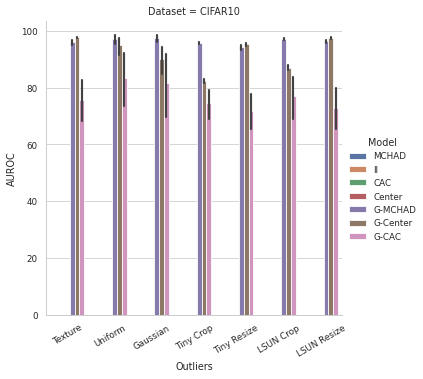

In [29]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["CIFAR10"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [30]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top">CIFAR10</th>
      <th>G-CAC</th>
      <td>72.95</td>
      <td>2.62</td>
      <td>76.74</td>
      <td>1.58</td>
      <td

In [31]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                       mean       sem       mean       sem       mean   
Dataset Model                                                           
CIFAR10 G-CAC     72.951429  2.622827  76.738891  1.584205  74.631645   
        G-Center  94.273809  0.014247  92.189500  0.617311  87.805644   
        G-MCHAD   94.720476  0.009985  96.415589  0.208653  93.792861   

                             AUPR-OUT                FPR95            
                       sem       mean       sem       mean       sem  
Dataset Model                                                         
CIFAR10 G-CAC     1.594329  76.992015  1.365731  62.677619  2.737043  
        G-Center  0.935805  93.966079  0.469483  21.308163  1.318531  
        G-MCHAD   0.409513  97.366978  0.151999  11.126871  0.580735

In [32]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> False 
Accuracy CIFAR10 -> False 
Accuracy CIFAR100 -> False 
AUROC SVHN -> False 
AUROC CIFAR10 -> False 
AUROC CIFAR100 -> False 
AUPR-IN SVHN -> False 
AUPR-IN CIFAR10 -> False 
AUPR-IN CIFAR100 -> False 
AUPR-OUT SVHN -> False 
AUPR-OUT CIFAR10 -> False 
AUPR-OUT CIFAR100 -> False 
FPR95 SVHN -> False 
FPR95 CIFAR10 -> False 
FPR95 CIFAR100 -> False 
